In [327]:
# -*- coding: utf-8 -*-
# @author: tongzi
# @description: Compressing Data via Dimensionality Reduction
# @created date: 2019/08/28
# @last modification: 2019/08/29



In [328]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plots as my_pl
%matplotlib inline

In [329]:
df_wine = pd.read_csv(r'https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)

In [330]:
df_wine.tail()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
173,3,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.7,0.64,1.74,740
174,3,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.3,0.70,1.56,750
175,3,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.2,0.59,1.56,835
176,3,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.3,0.60,1.62,840
177,3,14.13,4.10,2.74,24.5,96,2.05,0.76,0.56,1.35,9.2,0.61,1.60,560


In [331]:
from sklearn.cross_validation import train_test_split

In [332]:
from sklearn.preprocessing import StandardScaler

In [333]:
X, y = df_wine.iloc[:,1:].values, df_wine.iloc[:, 0].values

In [334]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                   random_state=0)

In [335]:
sc = StandardScaler()

In [336]:
X_train_std = sc.fit_transform(X_train)

In [337]:
X_test_std = sc.fit_transform(X_test)

### PCA

In [338]:
# np.cov()函数传进去的矩阵默认行是变量，列是观测值
# 因此需要将X_train_std进行转置
cov_mat = np.cov(X_train_std.T)

In [339]:
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

In [340]:
eigen_vals

array([4.8923083 , 2.46635032, 1.42809973, 1.01233462, 0.84906459,
       0.60181514, 0.52251546, 0.08414846, 0.33051429, 0.29595018,
       0.16831254, 0.21432212, 0.2399553 ])

variance explained ratio(方差解释率)：  
$$\frac{\lambda _j}{\sum^{d}_{j=1} \lambda_j}$$

In [341]:
tot = np.sum(eigen_vals)
var_exp = [(val / tot) for val in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

Text(0,0.5,'Explained variance ratio')

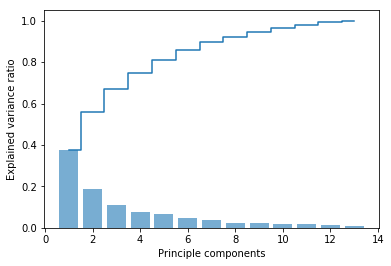

In [342]:
plt.bar(range(1, 14), var_exp, alpha=0.6, align='center', 
        label='individual expained variance')
plt.step(range(1, 14), cum_var_exp, where='mid', 
         label='cumulative explained variance')
plt.xlabel('Principle components')
plt.ylabel('Explained variance ratio')

In [343]:
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]

In [344]:
eigen_pairs.sort(reverse=True)

In [345]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis],
             eigen_pairs[1][1][:, np.newaxis]))

In [346]:
w

array([[ 0.14669811,  0.50417079],
       [-0.24224554,  0.24216889],
       [-0.02993442,  0.28698484],
       [-0.25519002, -0.06468718],
       [ 0.12079772,  0.22995385],
       [ 0.38934455,  0.09363991],
       [ 0.42326486,  0.01088622],
       [-0.30634956,  0.01870216],
       [ 0.30572219,  0.03040352],
       [-0.09869191,  0.54527081],
       [ 0.30032535, -0.27924322],
       [ 0.36821154, -0.174365  ],
       [ 0.29259713,  0.36315461]])

transformation to subspace:  
$$x^{\prime} = x W$$

In [347]:
X_train_std[0] @ w

array([2.59891628, 0.00484089])

$$X^{\prime} =  X W$$

In [348]:
X_train_pca = X_train_std @ w

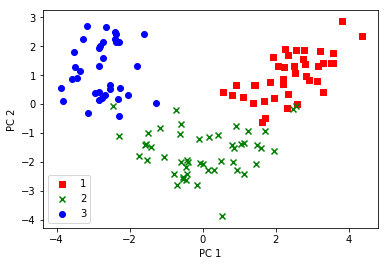

In [349]:
colors = ['r', 'g', 'b']
markers = ['s', 'x', 'o']
for cal, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train==cal, 0], X_train_pca[y_train==cal, 1],
               c=c, label=cal, marker=m)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')

In [350]:
from sklearn.decomposition import PCA

In [351]:
pca = PCA(n_components=None)

In [352]:
X_train_pca = pca.fit_transform(X_train_std)

In [353]:
pca.explained_variance_ratio_

array([0.37329648, 0.18818926, 0.10896791, 0.07724389, 0.06478595,
       0.04592014, 0.03986936, 0.02521914, 0.02258181, 0.01830924,
       0.01635336, 0.01284271, 0.00642076])

### LDA(Linear Discriminant Analysis)

In [354]:
mean_vecs = []
for label in range(1, 4):
    mean_vecs.append(np.mean(X_train_std[y_train == label,:], axis=0))

In [355]:
d = 13
S_W1 = np.zeros((d, d))

In [356]:
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = (X_train_std[y_train==label]-mv).T @ (X_train_std[y_train==label]-mv)
    S_W1 += class_scatter
    

In [357]:
d = 13
S_W2 = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.zeros((d, d))
    for row in X_train_std[y_train == label]:
        row, m = row.reshape(d, 1), mv.reshape(d, 1)
        class_scatter += (row - m) @ (row - m).T
    S_W2 += class_scatter

In [358]:
np.allclose(S_W1, S_W2)

True

In [359]:
print('Class label distribution: {}'.format(np.bincount(y_train)[1:]))

Class label distribution: [40 49 35]


In [360]:
d = 13
S_W3 = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    n = X_train_std[y_train == label].shape[0]
    print(f'samples={n}')
    class_scatter = np.cov((X_train_std[y_train == label] - mv).T) * n
    S_W3 += class_scatter

samples=40
samples=49
samples=35


In [361]:
np.allclose(S_W2, S_W3)

False

The between-class scatter matrix $S_B$:  
$$S_B = \sum \limits^{c}_{i=1} N_i (m_i - m)(m_i - m)^T $$


In [362]:
d = 13
mean_total = np.mean(X_train_std, axis=0)
S_B = np.zeros((d, d))
for i, mv in enumerate(mean_vecs):
    N = X_train_std[y_train==i+1].shape[0]
    #S_B += N * (mv - mean_total) @ (mv - mean_total).T
    mv = mv.reshape(d, 1)
    mean_overall = mean_total.reshape(d, 1)
    S_B += N * (mv - mean_overall) @ (mv - mean_overall).T

the eigenvalue of matrix $S^{-1}_wS_B$:  

In [363]:
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W1) @ S_B)

In [364]:
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]

In [365]:
# 由于有很多特征值大小十分相近，此时采用eigen_pairs.sort()无法排序
# 会抛出异常
eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)

In [366]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [367]:
lda = LinearDiscriminantAnalysis(n_components=2)

In [368]:
X_train_lda = lda.fit_transform(X_train_std, y_train)

In [369]:
from sklearn.linear_model import LogisticRegression

In [370]:
lr = LogisticRegression()

In [371]:
lr = lr.fit(X_train_lda, y_train)

In [381]:
from matplotlib.colors import ListedColormap
def plot_decision_regions(X, y, classifier, resolution=0.02):
    '''
    plot decision regions

    Parameters
    ------------
    X: array-like, shape=(n_samples, 2)
       the train array with a shape (n_samples, 2)
       
    y: 1D-vector with the same length as X

    classifier: object
       an estimator for classification
    resolution: scalar
        a step

    '''

    colors = ['red', 'blue', 'lightgreen', 'gray', 'cyan']
    markers = ['s', 'x', 'o', '^', 'v']
    cmap = ListedColormap(colors[:len(np.unique(y))])


    # plot decision regions
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)

    plt.contourf(xx1, xx2, Z, cmap=cmap, alpha=0.3)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    #plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y==cl, 0], y=X[y==cl, 1], alpha=0.8, c=cmap(idx), marker=markers[idx], label=cl)

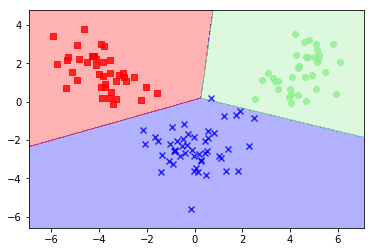

In [382]:
plot_decision_regions(X_train_lda, y_train, classifier=lr)

### Using kernel Principle Component Analysis for nonlinear mapping

The **Radial Basis Function**(RBF) or Gausian kernel:  
$$k(x^{(i)}, x^{(j)}) = \exp \big( - \frac{\parallel x^{(i)} - x^{(j)} \parallel ^2}{2 \sigma^2}\big)$$   
It is also written as follows:  
$$k(x^{(i)}, x^{(j)}) = \exp \big( - \gamma \parallel x^{(i)} - x^{(j)} \parallel ^2 \big)$$  

An RBF kernel PCA:  
(1)We compute the kernel (similarity) matrix $K$, where we need to calculate the following:  
$$k(x^{(i)}, x^{(j)}) = \exp \big( - \gamma \parallel x^{(i)} - x^{(j)} \parallel ^2 \big)$$  
We do this for each pair of samples:  
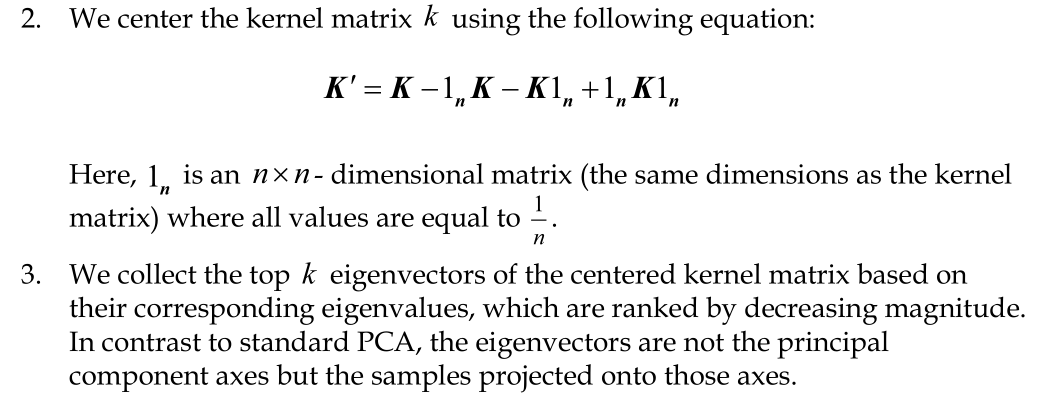  


### Implementing a kernel pricinple component analysis in Python

In [396]:
from scipy.spatial.distance import pdist, squareform
from scipy import exp
from scipy.linalg import eigh
def rbf_kernel_pca(X, gamma, n_components):
    # calculate pairwise squared Euclidean distances
    # in the M x N dimensional data set
    sq_dists = pdist(X, 'sqeuclidean')
    print(sq_dists)
    # convert pairwise matrix into a square matrix
    mat_sq_dists = squareform(sq_dists)
    print('\n\n', mat_sq_dists)
    #Compute the symmetric kernel matrix
    K = exp(-gamma * mat_sq_dists)
    
    # Center the kernel matrix
    N = K.shape[0]
    one_n = np.ones((N, N)) / N
    K = K - one_n @ K - K @ one_n + one_n @ K @ one_n
    
    #Obtaining eigenpairs from the centered kernel matrix
    # numpy.eigh() returns them in sorted order
    eigvals, eigvecs = eigh(K)
    
    # Collect the top k eigenvectors (projected samples)
    X_pc = np.column_stack((eigvecs[:, -i] for i in range(1, n_components+1)))
    return X_pc
    

### Example 1-separating half-moon shapes

In [391]:
from sklearn.datasets import make_moons

In [392]:
X, y = make_moons(n_samples=100, random_state=123)

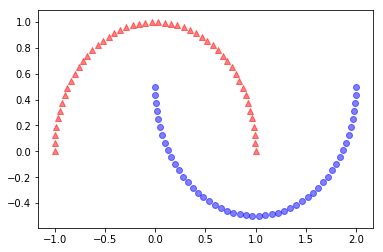

In [393]:
plt.scatter(X[y==0, 0], X[y==0, 1], color='red', marker='^', alpha=0.5)
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', marker='o', alpha=0.5)

In [394]:
from matplotlib.ticker import FormatStrFormatter

In [397]:
X_kpca = rbf_kernel_pca(X, gamma=15, n_components=2)

[0.92562071 1.11922547 1.43094483 ... 2.74227495 1.542287   2.19204605]


 [[0.         0.92562071 1.11922547 ... 0.32382379 1.24046572 0.86735455]
 [0.92562071 0.         0.5633013  ... 1.8737194  1.68080021 0.06541027]
 [1.11922547 0.5633013  0.         ... 2.62103471 0.39717276 0.96321486]
 ...
 [0.32382379 1.8737194  2.62103471 ... 0.         2.74227495 1.542287  ]
 [1.24046572 1.68080021 0.39717276 ... 2.74227495 0.         2.19204605]
 [0.86735455 0.06541027 0.96321486 ... 1.542287   2.19204605 0.        ]]


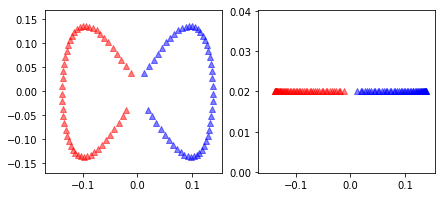

In [405]:
fig, axes = plt.subplots(1, 2, figsize=(7, 3))
axes[0].scatter(X_kpca[y==0, 0], X_kpca[y==0, 1],
               color='red', marker='^', alpha=0.5)
axes[0].scatter(X_kpca[y==1, 0], X_kpca[y==1, 1],
               color='blue', marker='^', alpha=0.5)
axes[1].scatter(X_kpca[y==0, 0], np.zeros((50,1))+0.02,
  color='red', marker='^', alpha=0.5)
axes[1].scatter(X_kpca[y==1, 0], np.zeros((50,1))+0.02,
  color='blue', marker='^', alpha=0.5)

### Example 2 - separating concentric circles

In [406]:
from sklearn.datasets import make_circles

In [407]:
X, y = make_circles(n_samples=1000, random_state=123, noise=0.1, factor=0.2)

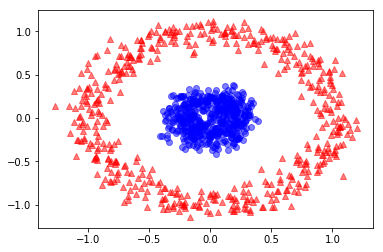

In [408]:
plt.scatter(X[y==0, 0], X[y==0, 1], color='red', marker='^', alpha=0.5)
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', marker='o', alpha=0.5)

In [409]:
X_kpca = rbf_kernel_pca(X, gamma=15, n_components=2)

[0.85245704 1.23733555 1.04834026 ... 0.17769146 1.30143331 1.20356293]


 [[0.         0.85245704 1.23733555 ... 4.44875623 4.35367112 0.98261989]
 [0.85245704 0.         2.68971248 ... 3.61846708 2.88128483 0.79533273]
 [1.23733555 2.68971248 0.         ... 2.23090635 2.86876086 0.8499729 ]
 ...
 [4.44875623 3.61846708 2.23090635 ... 0.         0.17769146 1.30143331]
 [4.35367112 2.88128483 2.86876086 ... 0.17769146 0.         1.20356293]
 [0.98261989 0.79533273 0.8499729  ... 1.30143331 1.20356293 0.        ]]


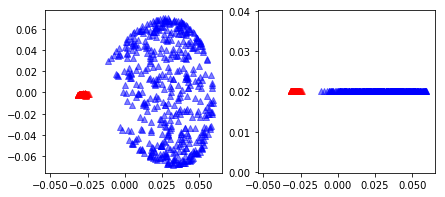

In [411]:
fig, axes = plt.subplots(1, 2, figsize=(7, 3))
axes[0].scatter(X_kpca[y==0, 0], X_kpca[y==0, 1],
               color='red', marker='^', alpha=0.5)
axes[0].scatter(X_kpca[y==1, 0], X_kpca[y==1, 1],
               color='blue', marker='^', alpha=0.5)
axes[1].scatter(X_kpca[y==0, 0], np.zeros((500,1))+0.02,
  color='red', marker='^', alpha=0.5)
axes[1].scatter(X_kpca[y==1, 0], np.zeros((500,1))+0.02,
  color='blue', marker='^', alpha=0.5)

In [413]:
from scipy.spatial.distance import pdist, squareform
from scipy import exp
from scipy.linalg import eigh
def rbf_kernel_pca(X, gamma, n_components):
    # calculate pairwise squared Euclidean distances
    # in the M x N dimensional data set
    sq_dists = pdist(X, 'sqeuclidean')
    print(sq_dists)
    # convert pairwise matrix into a square matrix
    mat_sq_dists = squareform(sq_dists)
    print('\n\n', mat_sq_dists)
    #Compute the symmetric kernel matrix
    K = exp(-gamma * mat_sq_dists)
    
    # Center the kernel matrix
    N = K.shape[0]
    one_n = np.ones((N, N)) / N
    K = K - one_n @ K - K @ one_n + one_n @ K @ one_n
    
    #Obtaining eigenpairs from the centered kernel matrix
    # numpy.eigh() returns them in sorted order
    eigvals, eigvecs = eigh(K)
    
    # Collect the top k eigenvectors (projected samples)
    alphas = np.column_stack((eigvecs[:, -i] for i in range(1, n_components+1)))
    lambdas = [eigvals[-i] for i in range(1, n_components+1)]
    return alphas, lambdas

### Kernel principle component analysis in scikit-learn

In [414]:
from sklearn.decomposition import KernelPCA

In [415]:
X, y = make_moons(n_samples=100, random_state=123)

In [416]:
scikit_kpca = KernelPCA(n_components=2, kernel='rbf', gamma=15)

In [417]:
X_skernpca = scikit_kpca.fit_transform(X)

Text(0,0.5,'PC2')

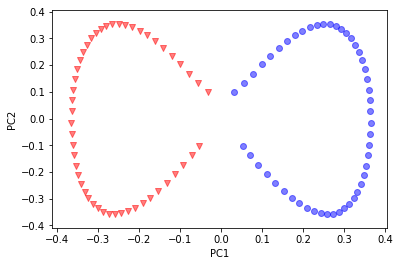

In [419]:
plt.scatter(X_skernpca[y==0, 0], X_skernpca[y==0, 1], color='red', marker='v',
           alpha=0.5)
plt.scatter(X_skernpca[y==1, 0], X_skernpca[y==1, 1], color='blue', marker='o',
           alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')